In [101]:
import os
import re
import json

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [104]:
# sns.color_palette("Set2")
sns.color_palette() 

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# Data preparation

Extract all log files, each files becomes a json of the following format, and all json objects are stored in a list `all_logs`

```
[
  {
    "file": <filepath>,
    "config": {
      "training": "augmented",
      "notation": "original",
      "model": "BiRNN",
      "epochs": 1000,
      "num_sets": 1,
      "save": true,
      "log": true,
      "config": "augmented-original"
    },
    "hyperparams": {
      "n_epochs": 1000,
      "batch_size": 200,
      "learning_rate": 0.00010615820833771753,
      "embedding_dim": 192,
      "hidden_size": 64,
      "num_layers": 1
    },
    "num_params": 102400,
    "loss": [<list_of_avg_loss>],
    "metrics": {
      "train": {
        "accucary": 0,
        "f1": 0,
        "loss": 0
      },
      "dev": {
        "accucary": 0,
        "f1": 0,
        "loss": 0
      }
    }
  }
]
```

Assuming this notebook has all trained model folders as siblings, like so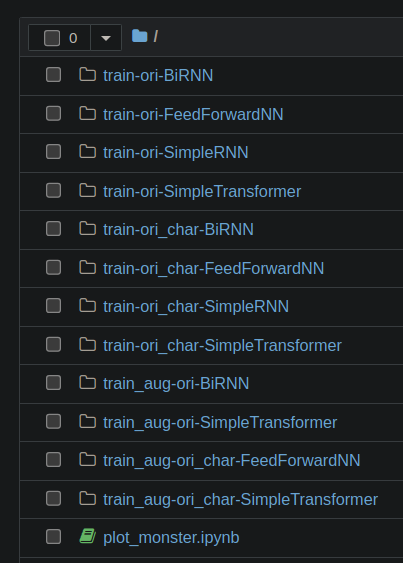

In [105]:
def extract_info(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    with open(file_path, 'r') as file:
        content = file.read()

    json_blocks = re.findall(r'\{[^{}]+\}', content)
    json_objects = [json.loads(block) for block in json_blocks]

    config = json_objects[0]
    hyperparams = json_objects[1]
    num_params = None
    loss = []
    train_metrics = {"accuracy": 0, "f1": 0, "loss": 0}
    dev_metrics = {"accuracy": 0, "f1": 0, "loss": 0}
    
    config_pattern = re.compile(r'Training with the following config: (.+)')
    hyperparams_pattern = re.compile(r'{(.+)}')
    num_params_pattern = re.compile(r'Model has ([\d,]+) parameters.')
    loss_pattern = re.compile(r'avg loss per example in epoch (\d+\.\d+)')
    train_metrics_pattern = re.compile(r'\[train\] Loss: (\d+\.\d+), Accuracy: (\d+\.\d+), F1-macro: (\d+\.\d+)')
    dev_metrics_pattern = re.compile(r'\[dev\]   Loss: (\d+\.\d+), Accuracy: (\d+\.\d+), F1-macro: (\d+\.\d+)')
    
    for line in lines:
        config_match = config_pattern.match(line)
        if config_match:
            config = json.loads(config_match.group(1).replace("'", '"'))
        
        hyperparams_match = hyperparams_pattern.match(line)
        if hyperparams_match:
            hyperparams = json.loads('{' + hyperparams_match.group(1) + '}')
        
        num_params_match = num_params_pattern.search(line)
        if num_params_match:
            num_params = int(num_params_match.group(1).replace(',', ''))
        
        loss_match = loss_pattern.search(line)
        if loss_match:
            loss.append(float(loss_match.group(1)))
        
        train_metrics_match = train_metrics_pattern.match(line)
        if train_metrics_match:
            train_metrics["loss"] = float(train_metrics_match.group(1))
            train_metrics["accuracy"] = float(train_metrics_match.group(2))
            train_metrics["f1"] = float(train_metrics_match.group(3))
        
        dev_metrics_match = dev_metrics_pattern.match(line)
        if dev_metrics_match:
            dev_metrics["loss"] = float(dev_metrics_match.group(1))
            dev_metrics["accuracy"] = float(dev_metrics_match.group(2))
            dev_metrics["f1"] = float(dev_metrics_match.group(3))
    
    config["config"] = f"{config['training']}_{config['notation']}"
    
    output_data = {
        "file": file_path,  # for easy back-trace 
        "config": config,
        "hyperparams": hyperparams,
        "num_params": num_params,
        "loss": loss,
        "metrics": {
            "train": train_metrics,
            "dev": dev_metrics
        }
    }
    
    return output_data


In [106]:
def get_log_filepaths(dirs):
    log_filepaths = []
    for d in dirs: 
        if not os.path.isdir(d):
            print(f"Folder {d} does not exist, skip.")
            continue
            
        for filename in os.listdir(d):
            if filename.endswith('.log'):
                log_filepaths.append(os.path.join(d, filename))

    return log_filepaths

In [107]:
def pretty_print(data: dict):
    print(json.dumps(data, indent=4))

In [108]:
BASE_PATHS = [
      "train-ori-", 
      "train-ori_char-",
      "train_aug-ori-",
      "train_aug-ori_char-",
]


MODEL_CLASSES = [
    "FeedForwardNN",
    "SimpleRNN", 
    "BiRNN", 
    "SimpleTransformer"
]

folders = [f"{b}{m}" for b in BASE_PATHS for m in MODEL_CLASSES]

folders

['train-ori-FeedForwardNN',
 'train-ori-SimpleRNN',
 'train-ori-BiRNN',
 'train-ori-SimpleTransformer',
 'train-ori_char-FeedForwardNN',
 'train-ori_char-SimpleRNN',
 'train-ori_char-BiRNN',
 'train-ori_char-SimpleTransformer',
 'train_aug-ori-FeedForwardNN',
 'train_aug-ori-SimpleRNN',
 'train_aug-ori-BiRNN',
 'train_aug-ori-SimpleTransformer',
 'train_aug-ori_char-FeedForwardNN',
 'train_aug-ori_char-SimpleRNN',
 'train_aug-ori_char-BiRNN',
 'train_aug-ori_char-SimpleTransformer']

In [109]:
log_filepaths = get_log_filepaths(folders)

In [110]:
all_logs = [extract_info(f) for f in log_filepaths]

In [111]:
pretty_print(all_logs[0])

{
    "file": "train-ori-FeedForwardNN/model-4.log",
    "config": {
        "training": "normal",
        "notation": "original",
        "model": "FFNN",
        "epochs": 1000,
        "num_sets": 6,
        "save": true,
        "log": true,
        "config": "normal_original"
    },
    "hyperparams": {
        "n_epochs": 1000,
        "batch_size": 300,
        "learning_rate": 0.09253285107912736,
        "embedding_dim": 256,
        "hidden_size": 128,
        "num_layers": 3
    },
    "num_params": 2419203,
    "loss": [
        1.0906638291995958,
        1.091084971777721,
        1.088079805705538,
        1.089102149285865,
        1.0861752189724603,
        1.088447826488598,
        1.0802558928382904,
        1.0723429511228584,
        1.0713573558910472,
        1.0676571643490589,
        1.0655151037267736,
        1.0627295393188947,
        1.0617935263144003,
        1.057689046381063,
        1.0518269000550495,
        1.0515429334014539,
        1.05608676

In [112]:
len(all_logs)

121

# Performance overview

## performance range of each model type

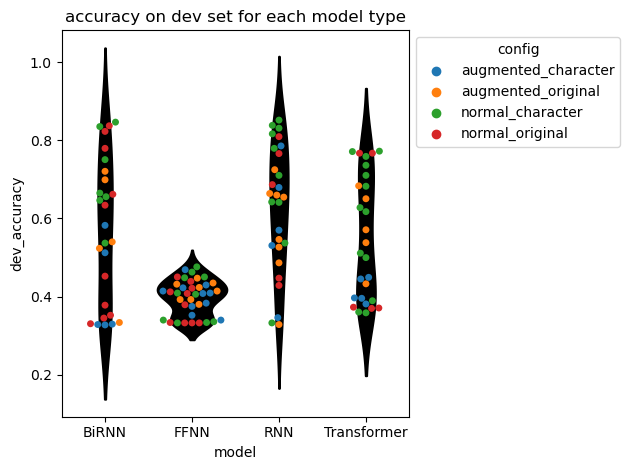

In [113]:
# dev accuracy range per model type
data = {
    'model': [l["config"]["model"] for l in all_logs],
    'dev_accuracy': [l["metrics"]["dev"]["accuracy"] for l in all_logs],
    'training': [l["config"]["training"] for l in all_logs],
    'notation': [l["config"]["notation"] for l in all_logs],
    'config': [l["config"]["config"] for l in all_logs],
}

df = pd.DataFrame(data)

df['model'] = pd.Categorical(df['model'])
df['training'] = pd.Categorical(df['training'])
df['notation'] = pd.Categorical(df['notation'])
df['config'] = pd.Categorical(df['config'])


sns.swarmplot(x='model', y='dev_accuracy', hue='config', data=df)
sns.violinplot(x='model', y='dev_accuracy', data=df, inner=None, color='k', alpha=0.3)

plt.title('accuracy on dev set for each model type')
plt.legend(title='config', bbox_to_anchor=(1, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

## closer look at performance per training set per model

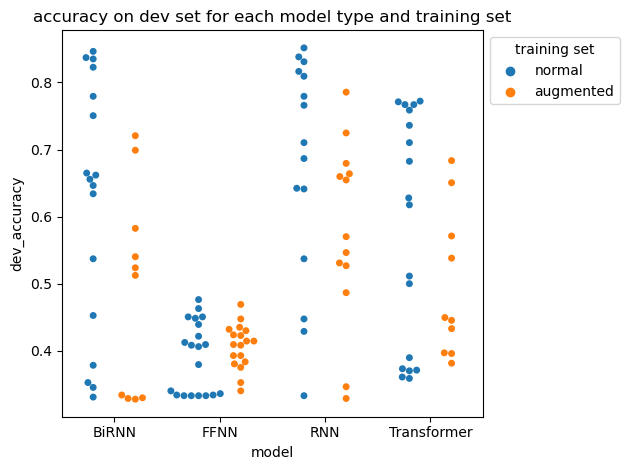

In [114]:
data = {
    'model': [l["config"]["model"] for l in all_logs],
    'dev_accuracy': [l["metrics"]["dev"]["accuracy"] for l in all_logs],
    'dataset': [l["config"]["training"] for l in all_logs]
}


df = pd.DataFrame(data)

df['model'] = pd.Categorical(df['model'])

sns.swarmplot(x='model', y='dev_accuracy', hue='dataset', dodge=True, data=df)

plt.title('accuracy on dev set for each model type and training set')
plt.legend(title='training set', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()  
plt.show()

## closer look at performance per notation per model

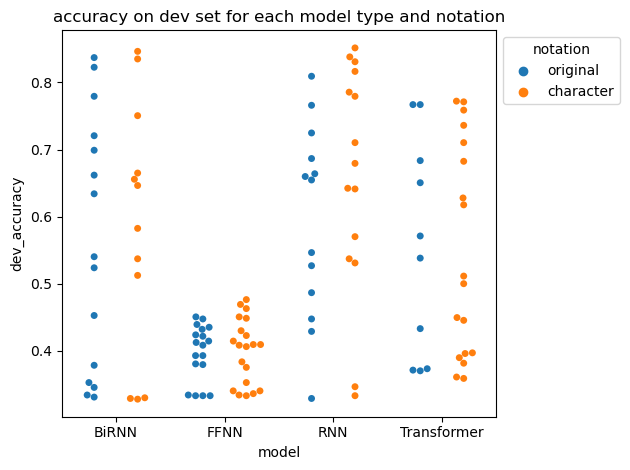

In [115]:
data = {
    'model': [l["config"]["model"] for l in all_logs],
    'dev_accuracy': [l["metrics"]["dev"]["accuracy"] for l in all_logs],
    'notation': [l["config"]["notation"] for l in all_logs]
}


df = pd.DataFrame(data)

df['model'] = pd.Categorical(df['model'])

sns.swarmplot(x='model', y='dev_accuracy', hue='notation', dodge=True, data=df)

plt.title('accuracy on dev set for each model type and notation')
plt.legend(title='notation', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()  
plt.show()

# performance against num_params

## dev_accuracy agains num_params

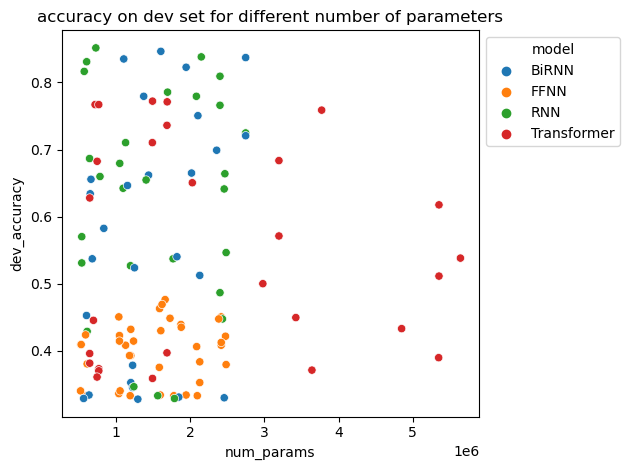

In [116]:
# dev accuracy range on diff num_params
data = {
    'model': [l["config"]["model"] for l in all_logs],
    'dev_accuracy': [l["metrics"]["dev"]["accuracy"] for l in all_logs],
    'num_params': [l["num_params"] for l in all_logs],
}

df = pd.DataFrame(data)

df['model'] = pd.Categorical(df['model'])

sns.scatterplot(x='num_params', y='dev_accuracy', hue='model', data=df)

plt.title('accuracy on dev set for different number of parameters')
plt.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

## dev_f1 agains num_params

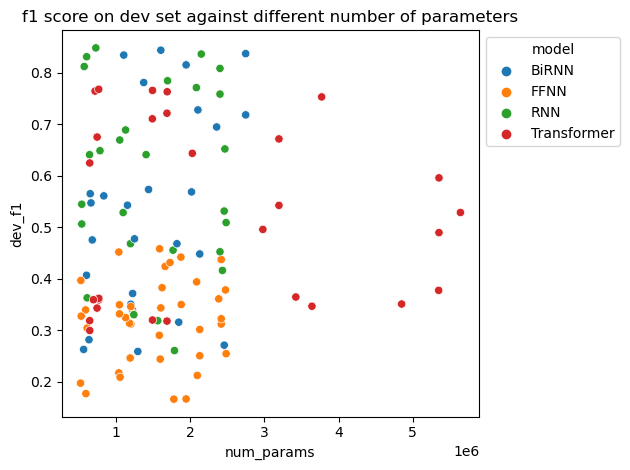

In [117]:
# dev accuracy range on diff num_params
data = {
    'model': [l["config"]["model"] for l in all_logs],
    'dev_accuracy': [l["metrics"]["dev"]["accuracy"] for l in all_logs],
    'dev_f1': [l["metrics"]["dev"]["f1"] for l in all_logs],
    'num_params': [l["num_params"] for l in all_logs],
}

df = pd.DataFrame(data)

df['model'] = pd.Categorical(df['model'])

sns.scatterplot(x='num_params', y='dev_f1', hue='model', data=df)

plt.title('f1 score on dev set against different number of parameters')
plt.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

# closer look at hyperparams of best and worst models of each type

## prepare data of models of extreme performance

* choose top 25% and bottom 25% of each model type as “best models” and "worst models" 
* look at each hyperparam
* color coding for diff model, shape coding for "best model" or "worst model" 

In [118]:
def get_extremes(logs, metric="accuracy", cut_off=0.25, top=True): 
    logs = sorted(logs, key=lambda l: l['metrics']['dev'][metric], reverse=top)
    cut_off = int(len(logs) * cut_off) 
    logs_top = logs[:cut_off]

    return logs_top

In [119]:
def filter_by_model(m): 
    return [l for l in all_logs if l["config"]["model"] == m]

In [120]:
bests = [
    *get_extremes((filter_by_model("FFNN")), top=True), 
    *get_extremes((filter_by_model("RNN")), top=True), 
    *get_extremes((filter_by_model("BiRNN")), top=True), 
    *get_extremes((filter_by_model("Transformer")), top=True), 
]

# make deep copy
bests = json.loads(json.dumps(bests))
bests = [{**l, "extreme": "best"} for l in bests]

print(len(bests))
pretty_print(bests[0])

29
{
    "file": "train-ori_char-FeedForwardNN/model-3.log",
    "config": {
        "training": "normal",
        "notation": "character",
        "model": "FFNN",
        "epochs": 1000,
        "num_sets": 10,
        "save": true,
        "log": true,
        "config": "normal_character"
    },
    "hyperparams": {
        "n_epochs": 1000,
        "batch_size": 300,
        "learning_rate": 0.09871962920287722,
        "embedding_dim": 192,
        "hidden_size": 256,
        "num_layers": 2
    },
    "num_params": 1663875,
    "loss": [
        1.0930931273942748,
        1.0887708202936475,
        1.0850926485393038,
        1.0813580534356901,
        1.073245875531642,
        1.0698663565735098,
        1.0649764743642918,
        1.0671652728342182,
        1.0587385305750785,
        1.0577590388588924,
        1.0488049834851592,
        1.0463922778980153,
        1.0455956701330236,
        1.0457040322793496,
        1.0493022668315637,
        1.0443219583283059,
   

In [121]:
worsts = [
    *get_extremes((filter_by_model("FFNN")), top=False), 
    *get_extremes((filter_by_model("RNN")), top=False), 
    *get_extremes((filter_by_model("BiRNN")), top=False), 
    *get_extremes((filter_by_model("Transformer")), top=False), 
]

# make deep copy
worsts = json.loads(json.dumps(worsts))
worsts = [{**l, "extreme": "worst"} for l in worsts]

print(len(worsts))
pretty_print(worsts[0])

29
{
    "file": "train-ori-FeedForwardNN/model-5.log",
    "config": {
        "training": "normal",
        "notation": "original",
        "model": "FFNN",
        "epochs": 1000,
        "num_sets": 6,
        "save": true,
        "log": true,
        "config": "normal_original"
    },
    "hyperparams": {
        "n_epochs": 1000,
        "batch_size": 200,
        "learning_rate": 0.00020120783789412923,
        "embedding_dim": 192,
        "hidden_size": 64,
        "num_layers": 2
    },
    "num_params": 1781379,
    "loss": [
        1.0992451412245114,
        1.0946076806263574,
        1.0938131301467484,
        1.0941011218214587,
        1.0944185164168074,
        1.0937997094820826,
        1.093113081648543,
        1.093541205564521,
        1.0943741292474813,
        1.0931988878876087,
        1.093295348178466,
        1.0923375769655677,
        1.0930704395191089,
        1.092391474072077,
        1.0918779810607204,
        1.0909388844847219,
        1.09

In [122]:
extremes = [
    *bests, 
    *worsts
]

In [123]:
# contains hyperparams of extreme models of all type, 
# some of them are None because certain model doesn't have it - deal with this later
data = {
    'dev_accuracy': [l["metrics"]["dev"]["accuracy"] for l in extremes],
    'dev_loss': [l["metrics"]["dev"]["loss"] for l in extremes],
    'dev_f1': [l["metrics"]["dev"]["f1"] for l in extremes],
    'num_params':[l['num_params'] for l in extremes] ,
    'extreme': [l['extreme'] for l in extremes],
    'model': [l["config"]["model"] for l in extremes],
    'batch_size': [l["hyperparams"]["batch_size"] for l in extremes],
    'learning_rate': [l["hyperparams"]["learning_rate"] for l in extremes],
    'embedding_dim': [l["hyperparams"]["embedding_dim"] for l in extremes],
    # only FFNN / RNN
    'hidden_size': [None if "hidden_size" not in l.get("hyperparams", {}) else l["hyperparams"]["hidden_size"] for l in extremes],
    # only FFNN / RNN
    'num_layers': [None if "num_layers" not in l.get("hyperparams", {}) else l["hyperparams"]["num_layers"] for l in extremes],
    # only Transformer
    'num_blocks': [None if "num_blocks" not in l.get("hyperparams", {}) else l["hyperparams"]["num_blocks"] for l in extremes],
    # only Transformer
    'num_heads': [None if "num_heads" not in l.get("hyperparams", {}) else l["hyperparams"]["num_heads"] for l in extremes],
}

df = pd.DataFrame(data)

df['model'] = pd.Categorical(df['model'])
df['extreme'] = pd.Categorical(df['extreme'])


## overview on best and worst models

### dev_accuracy against num_param for best and worst models

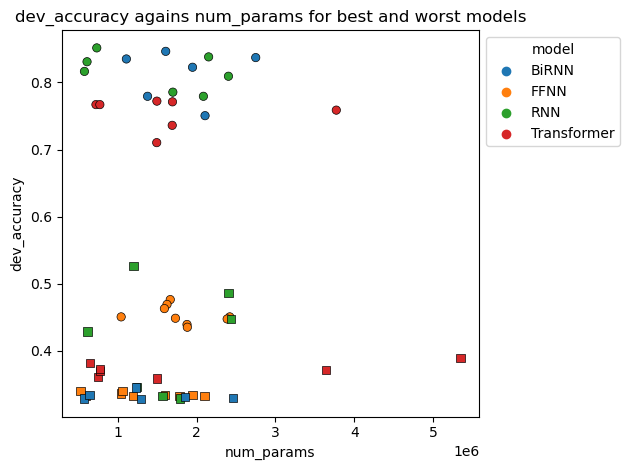

In [124]:
sns.scatterplot(x='num_params', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'best'], marker='o', edgecolor='black')
sns.scatterplot(x='num_params', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'worst'], marker='s', edgecolor='black', legend=False)

plt.title('dev_accuracy agains num_params for best and worst models')
plt.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

### dev_accuracy against dev_f1 for best and worst models

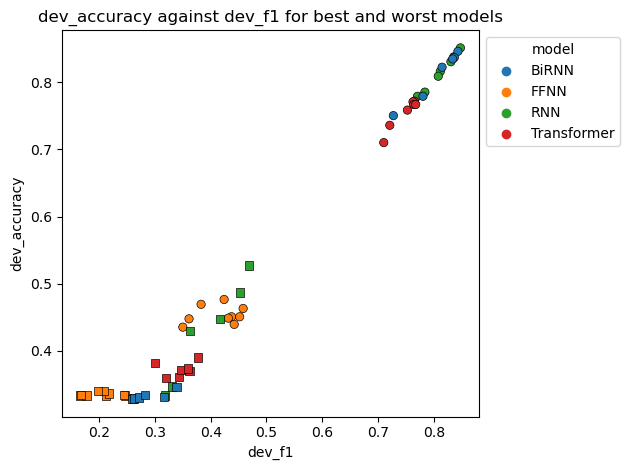

In [125]:
sns.scatterplot(x='dev_f1', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'best'], marker='o', edgecolor='black')
sns.scatterplot(x='dev_f1', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'worst'], marker='s', edgecolor='black', legend=False)

plt.title('dev_accuracy against dev_f1 for best and worst models')
plt.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')  
plt.tight_layout()  
plt.show()



## hyperparameters of best and worst models

### dev_accuracy against learning_rate for best and worst models

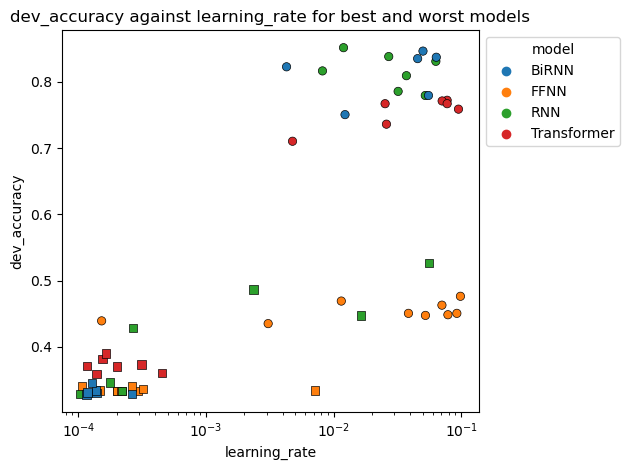

In [126]:
ax = sns.scatterplot(x='learning_rate', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'best'], marker='o', edgecolor='black')
sns.scatterplot(x='learning_rate', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'worst'], marker='s', edgecolor='black', ax=ax ,legend=False)

ax.set_xscale('log')

plt.title('dev_accuracy against learning_rate for best and worst models')
plt.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

### dev_accuracy against batch_size for best and worst models

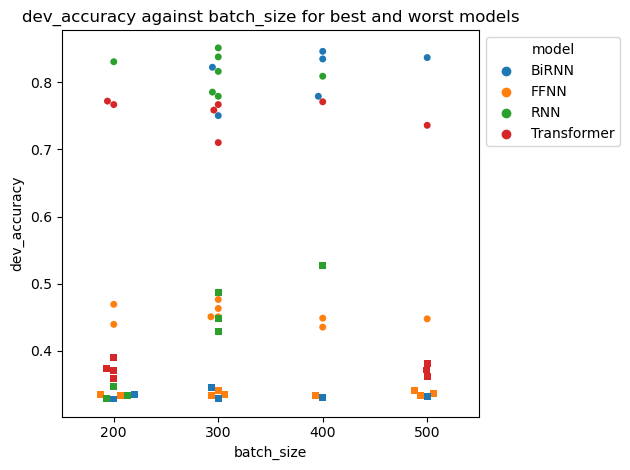

In [127]:
sns.swarmplot(x='batch_size', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'best'], marker='o', edgecolor='black')
sns.swarmplot(x='batch_size', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'worst'], marker='s', edgecolor='black', legend=False)

plt.title('dev_accuracy against batch_size for best and worst models')
plt.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

### dev_accuracy against embedding_dim for best and worst models

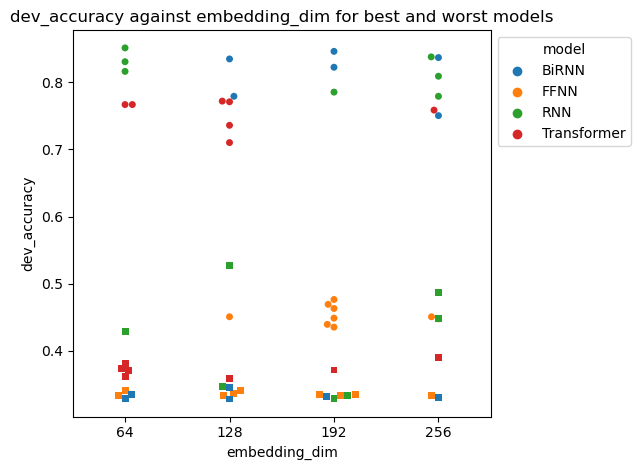

In [128]:
sns.swarmplot(x='embedding_dim', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'best'], marker='o', edgecolor='black')
sns.swarmplot(x='embedding_dim', y='dev_accuracy', hue='model', data=df[df['extreme'] == 'worst'], marker='s', edgecolor='black', legend=False)

plt.title('dev_accuracy against embedding_dim for best and worst models')
plt.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

### dev_accuracy against hidden_size for best and worst models

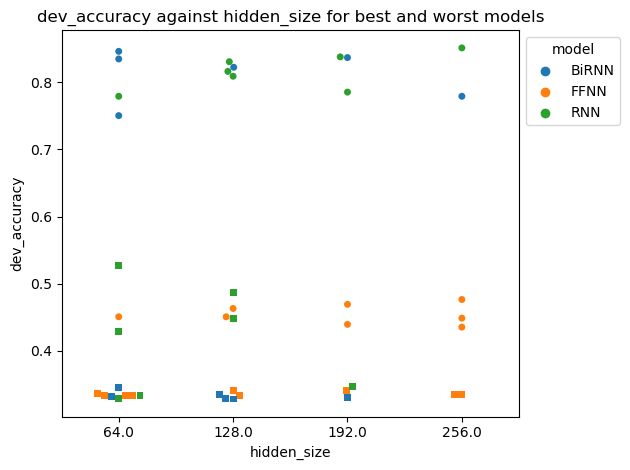

In [129]:
df_filtered = df.dropna(subset=['hidden_size'])

sns.swarmplot(x='hidden_size', y='dev_accuracy', hue='model', data=df_filtered[df_filtered['extreme'] == 'best'], marker='o', edgecolor='black')
sns.swarmplot(x='hidden_size', y='dev_accuracy', hue='model', data=df_filtered[df_filtered['extreme'] == 'worst'], marker='s', edgecolor='black', legend=False)

plt.title('dev_accuracy against hidden_size for best and worst models')

# Manually remove one of the labels
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label for label in labels if label != 'Transformer']
plt.legend(handles, labels, title='model', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()  
plt.show()

### dev_accuracy against num_layers for best and worst models

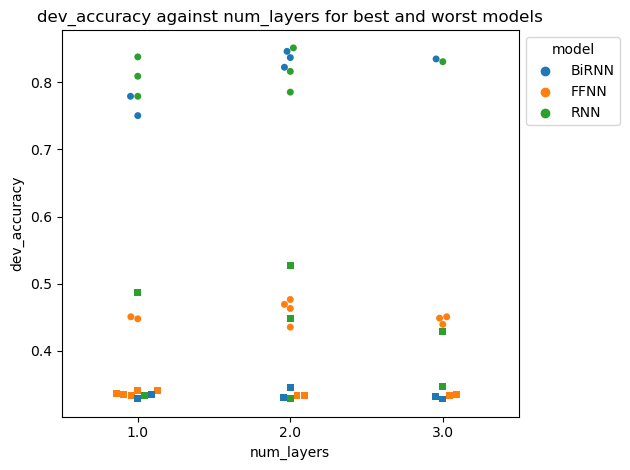

In [130]:
df_filtered = df.dropna(subset=['num_layers'])

sns.swarmplot(x='num_layers', y='dev_accuracy', hue='model', data=df_filtered[df_filtered['extreme'] == 'best'], marker='o', edgecolor='black')
sns.swarmplot(x='num_layers', y='dev_accuracy', hue='model', data=df_filtered[df_filtered['extreme'] == 'worst'], marker='s', edgecolor='black', legend=False)

plt.title('dev_accuracy against num_layers for best and worst models')

# Manually remove one of the labels
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label for label in labels if label != 'Transformer']
plt.legend(handles, labels, title='model', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()  
plt.show()

### dev_accuracy against num_blocks for best and worst models

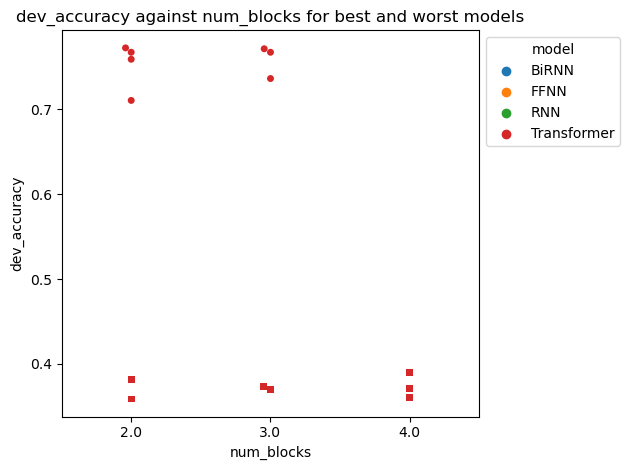

In [131]:
df_filtered = df.dropna(subset=['num_blocks'])

sns.swarmplot(x='num_blocks', y='dev_accuracy', hue='model', data=df_filtered[df_filtered['extreme'] == 'best'], marker='o', edgecolor='black')
sns.swarmplot(x='num_blocks', y='dev_accuracy', hue='model', data=df_filtered[df_filtered['extreme'] == 'worst'], marker='s', edgecolor='black', legend=False)

plt.title('dev_accuracy against num_blocks for best and worst models')

plt.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')  

plt.tight_layout()  
plt.show()

### dev_accuracy against num_heads for best and worst models

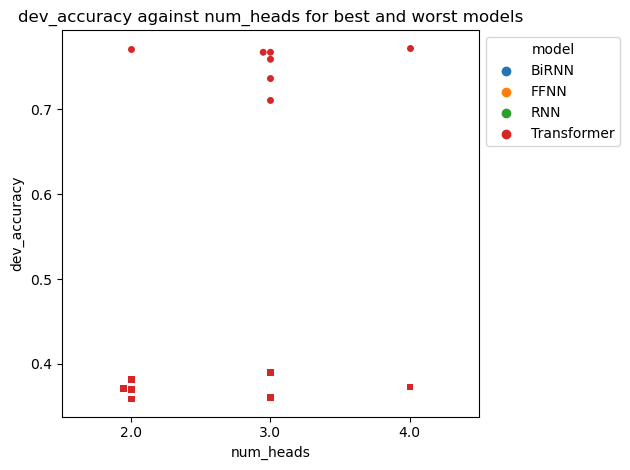

In [132]:
df_filtered = df.dropna(subset=['num_heads'])

sns.swarmplot(x='num_heads', y='dev_accuracy', hue='model', data=df_filtered[df_filtered['extreme'] == 'best'], marker='o', edgecolor='black')
sns.swarmplot(x='num_heads', y='dev_accuracy', hue='model', data=df_filtered[df_filtered['extreme'] == 'worst'], marker='s', edgecolor='black', legend=False)

plt.title('dev_accuracy against num_heads for best and worst models')

plt.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')  

plt.tight_layout()  
plt.show()

# End